# Updating figures under setting of option A

In [1]:
import numpy as np
import pandas as pd
import statistics
import matplotlib.pyplot as plt
from impyute.imputation.cs import fast_knn
from sklearn.metrics import roc_auc_score, roc_curve, f1_score
from matplotlib.colors import ListedColormap
from mlxtend.plotting import plot_decision_regions
from sklearn.decomposition import PCA
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from collections import OrderedDict
from mpl_toolkits.mplot3d import Axes3D
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, train_test_split, cross_val_score
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler

### loading the file and applying knn-imputation after encoding

In [2]:
df = pd.read_csv('dataset.txt', encoding='ISO-8859-1', delimiter='\t', dtype=str)
X = pd.get_dummies(df.iloc[:, 2:13])
new_columns = X.columns
labels = df.iloc[:, 2:13].columns
for feature_name in labels:
    X.loc[df.iloc[:, 2:13][feature_name].isnull(), X.columns.str.startswith(feature_name+'_')] = np.nan
X = np.array(X)
imputed_X=np.rint(fast_knn(X, k=30))
sc = StandardScaler()
X = sc.fit_transform(imputed_X)
y = df.iloc[:, 0]
y = np.where(y=='kontrol',0,1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=40)
lr_clf = LogisticRegression(solver='lbfgs')
rf_clf = RandomForestClassifier(n_estimators=10000)
svm_clf = SVC(gamma='auto', probability=True)

In [3]:
def plotPCA3D(column_num, name, only_cancer, filename):
    colors = ('orange','blue', 'green', 'brown', 'red', 'purple', 'gray')
    markers = ['o','s','X','v','<','P','>']
    column = np.array(df.iloc[:,column_num]).astype('str')[y == 1]
    unique_val = np.unique(column)
    plt.figure(figsize=(9,8))
    ax = plt.axes(projection="3d")
    for val, m, clr in zip(unique_val, markers, colors[:len(unique_val)]):
        for cor, colm  in zip(only_cancer, column):
            if colm == val:
                if colm == 'nan': continue
                else: ax.scatter(cor[0], cor[1], cor[2], marker=m, c=clr, label=val, s=30)

    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = OrderedDict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys())
    plt.title(name)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()

In [4]:
def draw_dendogram(column_number, title, filename, only_cancer, df=df):
    eliminated_nan_labels, eliminated_nan_pca = [], []
    label = np.array(df.iloc[:,column_number]).astype('str')[y == 1]
    for lbl, pca_values in zip(label, only_cancer):
        if lbl == 'nan': continue
        eliminated_nan_labels.append(lbl)
        eliminated_nan_pca.append(pca_values)
    variables = ['X', 'Y', 'Z']
    df = pd.DataFrame(eliminated_nan_pca, columns=variables, index=eliminated_nan_labels)
    row_dist = pd.DataFrame(squareform(pdist(df, metric='euclidean')),
                            columns=eliminated_nan_labels,
                            index=eliminated_nan_labels)
    
    row_clusters = linkage(df.values, method='complete', metric='euclidean')
    row_dendr = dendrogram(row_clusters, labels=eliminated_nan_labels,)
    plt.tight_layout()
    plt.ylabel('Euclidean distance')
    plt.title('Hierarchical Clustering Cancer Labeled With {}'.format(title))
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()

### calculating auc scores and plotting ROC in approach A

In [5]:
def getROCScores(classifier, X_train, y_train, X_test, y_test, label):
    classifier.fit(X_train, y_train)
    probs = classifier.predict_proba(X_test)
    probs = probs[:, 1]
    auc = roc_auc_score(y_test, probs)
    fpr, tpr, thresholds = roc_curve(y_test, probs)
    return auc, fpr, tpr, thresholds, label

In [6]:
def plotROC(scores, title, filename):
    plt.plot(scores[0][1], scores[0][2], marker='.', color='black', label='{}: {}'.format(scores[0][4], round(scores[0][0],2)))
    plt.plot(scores[1][1], scores[1][2], marker='.', color='red', label='{}: {}'.format(scores[1][4], round(scores[1][0],2)))
    plt.plot(scores[2][1], scores[2][2], marker='.', color='blue', label='{}: {}'.format(scores[2][4], round(scores[2][0],2)))
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.xlabel('False Positive')
    plt.ylabel('True Positive')
    plt.title(title)
    plt.legend()
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()

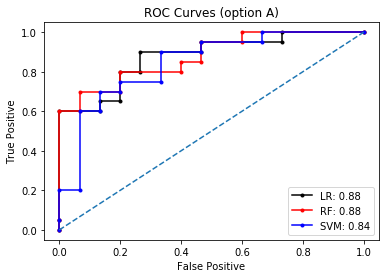

In [7]:
roc_lr = getROCScores(lr_clf, X_train, y_train, X_test, y_test, 'LR')
roc_rf = getROCScores(rf_clf, X_train, y_train, X_test, y_test, 'RF')
roc_svm = getROCScores(svm_clf, X_train, y_train, X_test, y_test, 'SVM')
plotROC([roc_lr, roc_rf, roc_svm], 'ROC Curves (option A)', 'roc_curves (option A)')

### plotting important features in approach A

In [8]:
def feature_importance(X_train, y_train, title, filename, labels):
    feat_labels = labels
    rf_clf.fit(X_train, y_train)
    importances = rf_clf.feature_importances_
    indices = np.argsort(importances)[::-1]
    plt.figure(figsize=(15,5))
    plt.title(title)
    plt.bar(range(X_train.shape[1]), importances[indices], color='lightgreen', align='center')
    plt.xticks(range(X_train.shape[1]), feat_labels[indices], rotation=90)
    plt.xlim([-1, X_train.shape[1]])
    plt.tight_layout()
    plt.savefig(filename, dpi=300)
    plt.show()

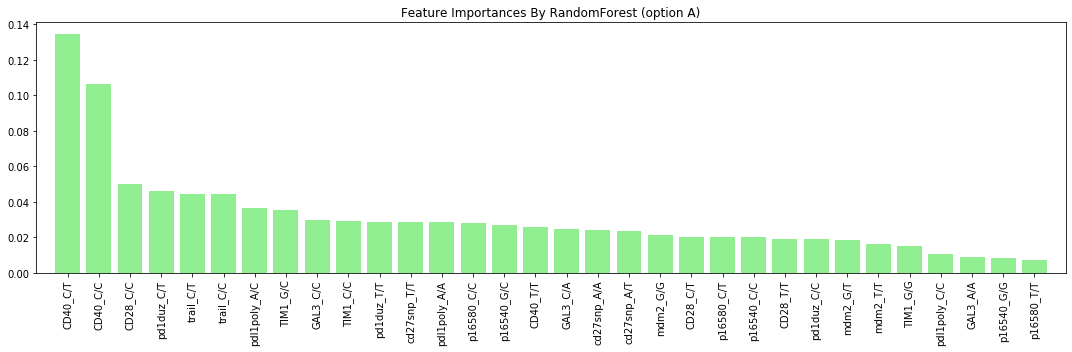

In [9]:
features_title = 'Feature Importances By RandomForest (option A)'
feature_importance(X_train, y_train, features_title, 'feature_importance (option A)', new_columns)

### plotting decision boundaries of option A

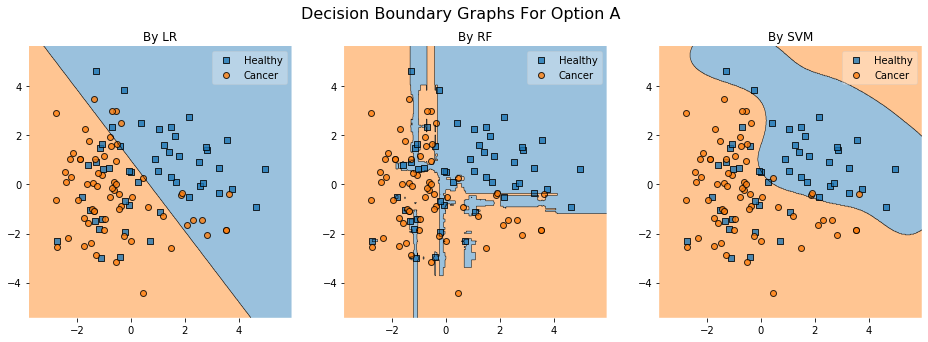

In [10]:
pca2d = PCA(n_components=2, random_state=40)
X_pca2d = pca2d.fit_transform(X)
lr_clf.fit(X_pca2d, y)
rf_clf.fit(X_pca2d, y)
svm_clf.fit(X_pca2d, y)
fig, ax = plt.subplots(1,3,figsize=(16,5))
plot_decision_regions(X_pca2d, y, lr_clf, ax=ax[0], markers='so')
plot_decision_regions(X_pca2d, y, rf_clf, ax=ax[1], markers='so')
plot_decision_regions(X_pca2d, y, svm_clf, ax=ax[2], markers='so')
for i in range(3):
    handles, labels = ax[i].get_legend_handles_labels()
    ax[i].legend(handles, ['Healthy', 'Cancer'], framealpha=0.3, scatterpoints=1)
ax[0].set_title('By LR')
ax[1].set_title('By RF')
ax[2].set_title('By SVM')
fig.suptitle('Decision Boundary Graphs For Option A', y=0.99, fontsize=16)
plt.savefig('decision boundaries of A', dpi=300, bbox_inches='tight')
plt.show()

### 3D PCA analysis of option A

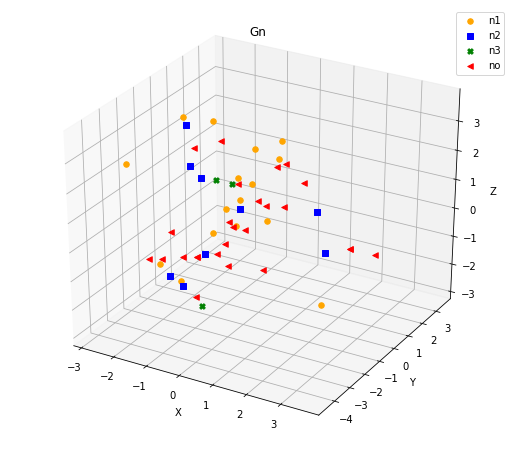

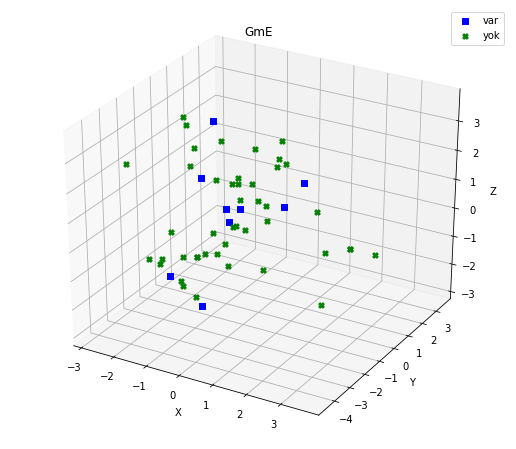

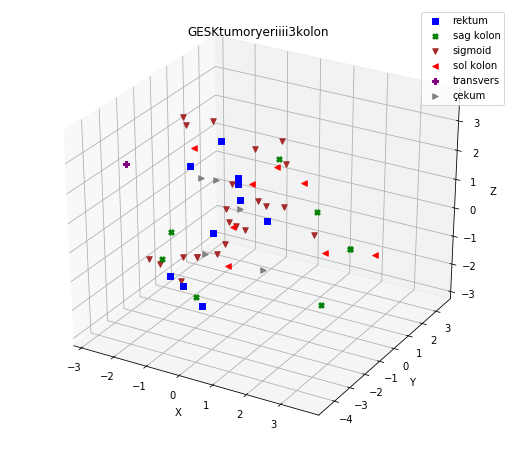

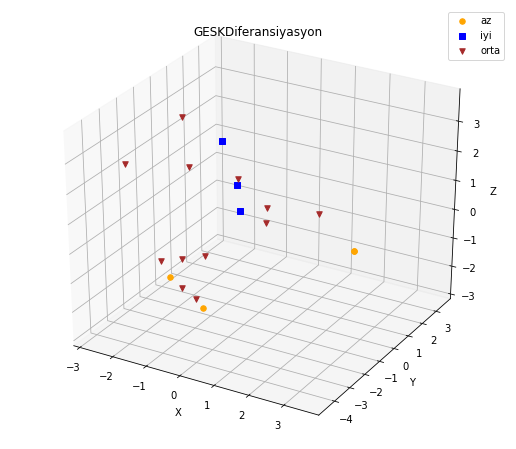

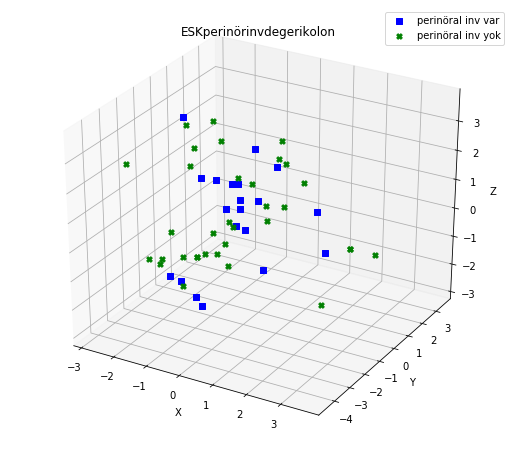

In [11]:
pca = PCA(n_components=3)
X_pca3d = pca.fit_transform(X)
cancer = X_pca3d[y == 1]
plotPCA3D(13, 'GTE3', cancer, 'PCA3D_GTE3')
plotPCA3D(14, 'Gn', cancer, 'PCA3D_Gn')
plotPCA3D(15, 'GmE', cancer, 'PCA3D_GmE')
plotPCA3D(16, 'GESKtumoryeriiii3kolon', cancer, 'PCA3D_GESKtumoryeriiii3kolon')
plotPCA3D(17, 'GESKDiferansiyasyon', cancer, 'PCA3D_GESKDiferansiyasyon')
plotPCA3D(18, 'ESKperinörinvdegerikolon', cancer, 'PCA3D_ESKperinörinvdegerikolon')

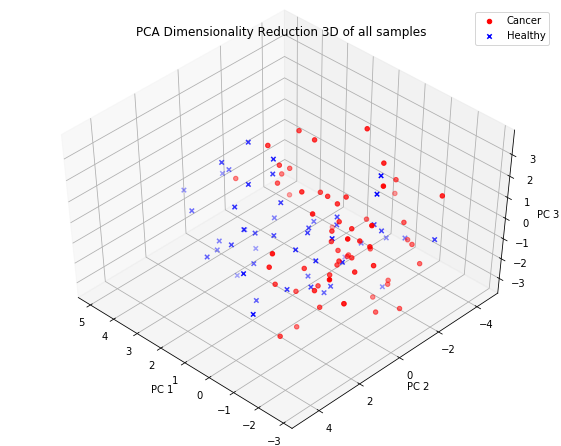

In [12]:
fig = plt.figure(1, figsize=(8, 6))
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)
c_pca1, c_pca2, c_pca3, h_pca1, h_pca2, h_pca3 = [], [], [], [], [], []
for i in range(115):
    if y[i]==1:
        c_pca1.append(X_pca3d[i, 0])
        c_pca2.append(X_pca3d[i, 1])
        c_pca3.append(X_pca3d[i, 2])
    else:
        h_pca1.append(X_pca3d[i, 0])
        h_pca2.append(X_pca3d[i, 1])
        h_pca3.append(X_pca3d[i, 2])
ax.scatter(c_pca1, c_pca2, c_pca3, c='r', marker='o', label='Cancer')
ax.scatter(h_pca1, h_pca2, h_pca3, c='b', marker='x', label='Healthy')
ax.legend()
ax.set_xlabel('PC 1')
ax.set_ylabel('PC 2')
ax.set_zlabel('PC 3')
plt.title('PCA Dimensionality Reduction 3D of all samples')
plt.savefig('pca of all samples.png', dpi=300, bbox_inches='tight')
plt.show()

### hierarchical clustering analysis of option A

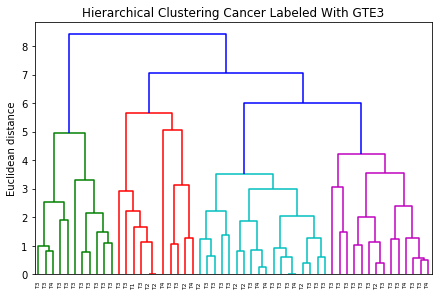

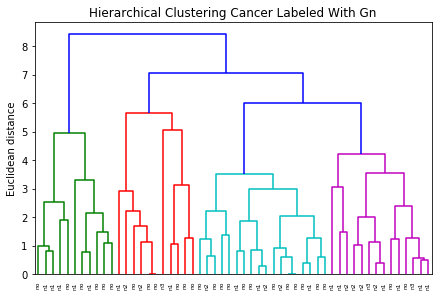

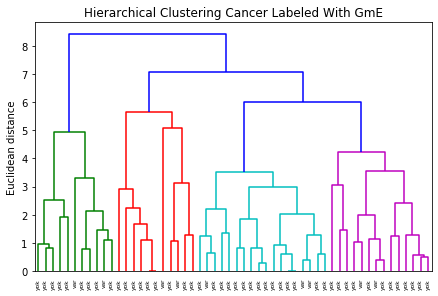

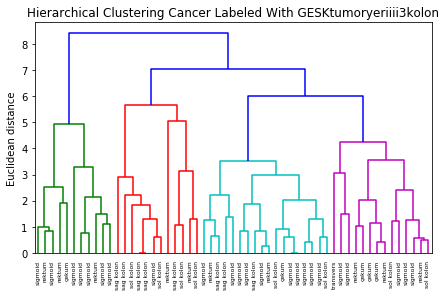

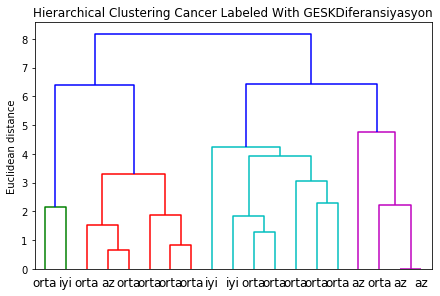

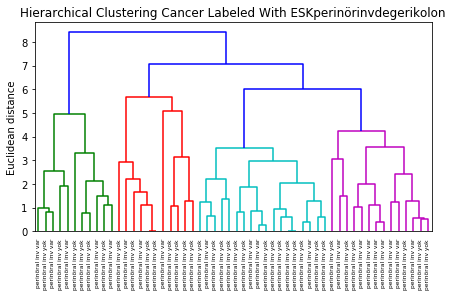

In [13]:
draw_dendogram(13, 'GTE3', 'hierarchical clustering analysis - GTE3', cancer)
draw_dendogram(14, 'Gn', 'hierarchical clustering analysis - Gn', cancer)
draw_dendogram(15, 'GmE', 'hierarchical clustering analysis - GmE', cancer)
draw_dendogram(16, 'GESKtumoryeriiii3kolon', 'hierarchical clustering analysis - GESKtumoryeriiii3kolon', cancer)
draw_dendogram(17, 'GESKDiferansiyasyon', 'hierarchical clustering analysis - GESKDiferansiyasyon', cancer)
draw_dendogram(18, 'ESKperinörinvdegerikolon', 'hierarchical clustering analysis - ESKperinörinvdegerikolon', cancer)